# Prepare Data

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:

from roboflow import Roboflow
rf = Roboflow(api_key="dZtrnF63aDa6P0VhuGkj")
project = rf.workspace("fyp-pz5zs").project("violence-nonviolence-behavior")
version = project.version(34)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


# Train Yolov8

In [3]:
from ultralytics import YOLO
model = YOLO('./content/violence_weights.pt')  # load a pretrained YOLOv8n detection model
# model.train(data='/content/drive/MyDrive/NTI_GP/Violence-NonViolence-Behavior-34/data.yaml', epochs=30)  # train the model

In [10]:
# from ultralytics import YOLO
# model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n detection model

# Video Analysis

In [2]:
import torch
import cv2
from ultralytics import YOLO

# Define path to video file
source = "./content/video1.webm"

# Load the YOLOv8 model and custom weights
model = YOLO('./content/violence_weights.pt')  # Start with a YOLOv8 base model (yolov8n.pt or similar)
# model.load('/content/violence_weights.pt')  # Load custom weights


# Run inference on the source
results = model(source, stream=True)  # generator of Results objects

### Extract Frames

In [3]:
import cv2
import os

# Initialize a list to hold frames (optional if you want to save them directly)
frames = []

# Specify the output folder where the frames will be saved
output_folder = 'extracted_frames'
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Specify how often to save frames, e.g., every 10th frame
frame_interval = 10  # Extract every 10th frame

# Process results list
for idx, result in enumerate(results):
    # Only extract and save every 'frame_interval' frame
    if idx % frame_interval == 0:
        # Extract result details (if needed)
        boxes = result.boxes
        masks = result.masks
        keypoints = result.keypoints
        probs = result.probs
        obb = result.obb

        # Use result.plot() to get the annotated image as a NumPy array
        annotated_frame = result.plot(boxes=False)
        frames.append(annotated_frame)

        # Construct the filename for the image
        image_filename = os.path.join(output_folder, f'frame_{idx:04d}.png')  # e.g., frame_0001.png

        # Save the frame as an image file
        cv2.imwrite(image_filename, annotated_frame)

print(f"Selected frames have been saved to the folder: {output_folder}")



video 1/1 (frame 1/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 2 nonviolences, 2 violences, 67.3ms
video 1/1 (frame 2/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 nonviolence, 2 violences, 3.1ms
video 1/1 (frame 3/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 nonviolence, 1 violence, 3.1ms
video 1/1 (frame 4/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 violence, 3.1ms
video 1/1 (frame 5/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 2 violences, 3.1ms
video 1/1 (frame 6/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 nonviolence, 2 violences, 3.1ms
video 1/1 (frame 7/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 violence, 3.1ms
video 1/1 (frame 8/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 violence, 3.1ms
video 1/1 (frame 9/2605) /home/umakant/Documents/BTP/content/video1.webm: 384x640 1 nonviolence, 1 violence, 3.1ms
video 1/1 (frame 1

In [14]:
# !pip install transformers --quiet

### Generate Cpations

In [7]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration,BlipForConditionalGeneration,BlipProcessor
import torch
# Load BLIP-2 processor and model for caption generation
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to("cuda")





In [8]:
import os
import cv2
import torch
from ultralytics import YOLO
from transformers import AutoProcessor, Blip2ForConditionalGeneration
# Load YOLOv8 model for violence detection
yolo_model = YOLO('./content/violence_weights.pt')


# Function to generate caption using BLIP-2
def generate_caption(frame):
    inputs = processor(images=frame, return_tensors="pt").to("cuda", torch.float16)
    with torch.no_grad():
        generated_ids = caption_model.generate(**inputs, max_length=50)
        caption = processor.decode(generated_ids[0], skip_special_tokens=True)
    return caption

# Function to overlay caption on the frame
def overlay_caption_on_frame(frame, caption):
    # Set font and positioning for the caption
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    caption_color = (255, 255, 255)  # White text
    text_position = (50, 50)  # Position of the text on the frame

    # Draw the caption on the frame
    cv2.putText(frame, caption, text_position, font, font_scale, caption_color, font_thickness, cv2.LINE_AA)
    return frame

# Define folders and process results
output_folder = 'processed_frames'
captions_file = 'captions.txt3'  # Ensure correct path for captions
os.makedirs(output_folder, exist_ok=True)

# Open the file to save captions
with open(captions_file, 'w') as f:
    # Load frames from the directory
    frames_folder = './extracted_frames'
    frame_files = [os.path.join(frames_folder, file) for file in os.listdir(frames_folder) if file.endswith(('.png', '.jpg'))]

    for idx, frame_path in enumerate(frame_files):
        # Load the frame
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"Error loading frame {frame_path}. Skipping.")
            continue

        # Generate a caption using BLIP-2
        caption = generate_caption(frame)

        if caption:  # Check if the caption is not empty
            print(f"Generated caption for frame {idx}: {caption}")

            # Overlay caption on the frame
            annotated_frame_with_caption = overlay_caption_on_frame(frame, caption)

            # Save the frame with caption overlay
            frame_filename = os.path.join(output_folder, f'frame_{idx:04d}.png')
            cv2.imwrite(frame_filename, annotated_frame_with_caption)

            # Save the caption in the captions file
            f.write(f"Frame {idx:04d}: {caption}\n")
        else:
            print(f"Warning: No caption generated for frame {idx}")

print(f"Processed frames saved to {output_folder} and captions saved to {captions_file}")

Generated caption for frame 0: there are three people in a boat with umbrellas on the water
Generated caption for frame 1: there are three people in a boat with umbrellas on the water
Generated caption for frame 2: arafed couple in traditional indian attire looking at each other
Generated caption for frame 3: bride and groom in traditional indian wedding attire, black and white photo
Generated caption for frame 4: arafed couple in traditional indian attire looking at a cell phone
Generated caption for frame 5: arafed man and woman in traditional indian clothing posing for a picture
Generated caption for frame 6: arafed couple in traditional indian attire looking at a cell phone
Generated caption for frame 7: arafed couple in traditional indian attire posing for a picture
Generated caption for frame 8: arafed couple in traditional indian attire posing for a picture
Generated caption for frame 9: arafed couple in traditional indian attire posing for a picture
Generated caption for frame 

In [2]:
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
import matplotlib.pyplot as plt

2024-12-01 23:48:54.897341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 23:48:55.014867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733077135.062707   14770 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733077135.074907   14770 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 23:48:55.154272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

/home/umakant/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [6]:
input_image= Image.open('./extracted_frames/frame_0010.png')
image_2= Image.open('./extracted_frames/frame_0010.png')
input_image = input_image.resize((224, 224)) 

Script starting...
Starting main function...
CUDA is available, clearing cache...
Using device: cuda
Checking for model and processor...
Model and processor found
Model type: <class 'transformers_modules.microsoft.Florence-2-large.f0acedbf9b780e04fe1f9111fcf53187388f3d03.modeling_florence2.Florence2ForConditionalGeneration'>
Processor type: <class 'transformers_modules.microsoft.Florence-2-large.f0acedbf9b780e04fe1f9111fcf53187388f3d03.processing_florence2.Florence2Processor'>
Attempting to load image...
Image path: ./extracted_frames/frame_0100.png
Image processed successfully. Size: (224, 224)
Attempting to generate caption...
Input image size: (224, 224)
Input image mode: RGB
Processing image with dimensions: 224x224
Unexpected error in caption generation: can't convert negative int to unsigned
Error type: <class 'OverflowError'>
Generated caption: Error generating caption
Attempting to display results...


Traceback (most recent call last):
  File "/tmp/ipykernel_14770/3656270577.py", line 17, in generate_caption
    inputs = processor(
             ^^^^^^^^^^
  File "/home/umakant/.cache/huggingface/modules/transformers_modules/microsoft/Florence-2-large/f0acedbf9b780e04fe1f9111fcf53187388f3d03/processing_florence2.py", line 270, in __call__
    inputs = self.tokenizer(
             ^^^^^^^^^^^^^^^
  File "/home/umakant/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py", line 3021, in __call__
    encodings = self._call_one(text=text, text_pair=text_pair, **all_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/umakant/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py", line 3109, in _call_one
    return self.batch_encode_plus(
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/umakant/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py", line 3311, in batch_encode_p

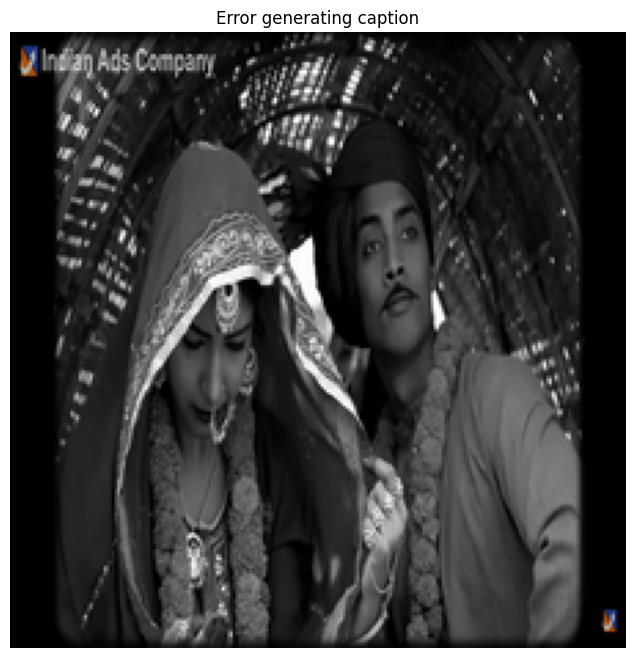

Display completed
Script completed


In [14]:
def main():
    try:
        print("Starting main function...")
        
        # Clear GPU memory
        if torch.cuda.is_available():
            print("CUDA is available, clearing cache...")
            torch.cuda.empty_cache()
            gc.collect()
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
        # Check if model and processor exist
        print("Checking for model and processor...")
        if 'model' not in globals() or 'processor' not in globals():
            print("Error: Model and processor not found in global scope")
            print("Available globals:", [k for k in globals().keys() if not k.startswith('_')])
            return
            
        print("Model and processor found")
        print(f"Model type: {type(model)}")
        print(f"Processor type: {type(processor)}")
        
        # Load and process image
        print("Attempting to load image...")
        try:
            image_path = "./extracted_frames/frame_0100.png"
            print(f"Image path: {image_path}")
            if not os.path.exists(image_path):
                print(f"Error: Image file not found at {image_path}")
                return
                
            input_image = process_image(image_path)
            print(f"Image processed successfully. Size: {input_image.size}")
            
        except Exception as e:
            print(f"Failed to load or process image: {str(e)}")
            print("Stack trace:")
            import traceback
            traceback.print_exc()
            return
            
        # Generate caption
        print("Attempting to generate caption...")
        caption = generate_caption(processor, model, input_image, device)
        print(f"Generated caption: {caption}")
        
        # Display results
        print("Attempting to display results...")
        display_image_with_caption(input_image, caption)
        print("Display completed")
        
    except Exception as e:
        print(f"Main execution error: {str(e)}")
        print("Stack trace:")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    print("Script starting...")
    import os  # Add import at top
    main()
    print("Script completed")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-11-22 19:22:44.126384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 19:22:44.135353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732283564.146494   30590 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732283564.149606   30590 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 19:22:44.160633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [12]:
def generate_caption(processor, model, input_image, device):
    try:
        # Print image info for debugging
        print(f"Input image size: {input_image.size}")
        print(f"Input image mode: {input_image.mode}")
        
        # Ensure image is RGB
        if input_image.mode != 'RGB':
            input_image = input_image.convert('RGB')
            
        # Get image dimensions as positive integers
        width = max(1, input_image.width)
        height = max(1, input_image.height)
        print(f"Processing image with dimensions: {width}x{height}")
        
        # Process input with explicit size handling
        inputs = processor(
            text='<CAPTION>',
            images=input_image,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        
        # Print shape information for debugging
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                print(f"{k} tensor shape: {v.shape}")
        
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate with error catching
        try:
            with torch.no_grad():
                generated_ids = model.generate(
                    input_ids=inputs["input_ids"],
                    pixel_values=inputs["pixel_values"],
                    max_new_tokens=128,
                    do_sample=False,
                    num_beams=2,
                    length_penalty=1.0,
                    early_stopping=True,
                    use_cache=True
                )
        except RuntimeError as e:
            print(f"Generation error: {str(e)}")
            raise
            
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        
        # Use absolute positive values for image size
        image_size = (abs(int(width)), abs(int(height)))
        print(f"Post-processing with size: {image_size}")
        
        parsed_answer = processor.post_process_generation(
            generated_text,
            task='<CAPTION>',
            image_size=image_size
        )
        
        return parsed_answer
        
    except RuntimeError as e:
        print(f"Runtime error in caption generation: {str(e)}")
        print(f"Device: {device}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"CUDA memory allocated: {torch.cuda.memory_allocated()}")
        return "Error generating caption"
    except Exception as e:
        print(f"Unexpected error in caption generation: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        traceback.print_exc()
        return "Error generating caption"